### 必要なライブラリのロード

In [9]:
import tensorflow as tf

from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import pickle

### データの準備

In [10]:
# データのロード
#訓練データ
dataset = []
for i in range(5):
    with open('cifar-10-batches-py/data_batch_'+str(i+1), 'rb') as f:
        dataset.append(pickle.load(f, encoding='bytes'))
X_train, T_train = [], []
for i in range(5):
    X_train.extend(dataset[i][b'data']), T_train.extend(dataset[i][b'labels'])
X_train = np.asarray(X_train).reshape(-1, 3, 32, 32).transpose(0,2,3,1)
T_train = np.asarray(T_train)
X_train = X_train/255.
#テストデータ
with open('cifar-10-batches-py/test_batch', 'rb') as f:
    dataset = pickle.load(f, encoding='bytes')
X_test, T_test = dataset[b'data'], dataset[b'labels']
X_test = np.asarray(X_test).reshape(-1, 3, 32, 32).transpose(0,2,3,1)
T_test = np.asarray(T_test)
X_test = X_test/255.

# データのサイズ
N_train = X_train.shape[0]
N_test = X_test.shape[0]

# ラベルデータをint型に統一し，学習に使いやすいようにone-hot-vectorに変換
T_train = np.eye(10)[T_train.astype("int")]
T_test = np.eye(10)[T_test.astype("int")]

訓練データのサイズは 50000
テストデータのサイズは 10000
画像データのshapeは (50000, 32, 32, 3)
ラベルデータのshapeは (50000, 10)
画像データの例：
ラベルデータの数値の例：
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


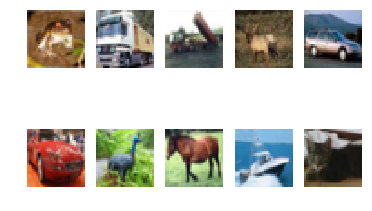

In [13]:
print ('訓練データのサイズは', N_train)
print ('テストデータのサイズは', N_test)
print ('画像データのshapeは', X_train.shape)
print ('ラベルデータのshapeは', T_train.shape)
print ('画像データの例：')
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    plt.axis('off')
print ('ラベルデータの数値の例：')
print (T_train[:10])

### ネットワーク構造

In [25]:
def CNN(x, training):
    input_layer = tf.reshape(x, [-1, 32, 32, 3])
    
    conv1 = tf.layers.conv2d(input_layer, filters=32, kernel_size=3, padding="same")
    act1 = tf.nn.relu(conv1)
    
    conv2 = tf.layers.conv2d(act1, filters=32, kernel_size=3, padding="same")
    act2 = tf.nn.relu(conv2)
    
    pool1 = tf.layers.max_pooling2d(act2, pool_size=2, strides=2)
    drop1 = tf.layers.dropout(pool1, 0.5, training=training)
    
    conv3 = tf.layers.conv2d(drop1, filters=64, kernel_size=3, padding="same")
    act3 = tf.nn.relu(conv3)
    
    conv4 = tf.layers.conv2d(act3, filters=64, kernel_size=3, padding="same")
    act4 = tf.nn.relu(conv4)
    
    pool2 = tf.layers.max_pooling2d(act4, pool_size=[2, 2], strides=2)
    drop2 = tf.layers.dropout(pool2, 0.5, training=training)
    
    conv5 = tf.layers.conv2d(drop2, filters=128, kernel_size=3, padding="same")
    act5 = tf.nn.relu(conv5)
    
    conv6 = tf.layers.conv2d(act5, filters=128, kernel_size=3, padding="same")
    act6 = tf.nn.relu(conv6)
        
    pool3 = tf.layers.max_pooling2d(act6, pool_size=[2, 2], strides=2)
    drop3 = tf.layers.dropout(pool3, 0.5, training=training)
    
    print(drop3.get_shape())
    
    # 2次元テンソルに変換
    flat = tf.reshape(drop3, [-1, 4*4*128])
    fc1 = tf.layers.dense(flat, 1024, activation=tf.nn.relu)
    fc2 = tf.layers.dense(fc1, 1024, activation=tf.nn.relu)
    out = tf.layers.dense(fc2, 10)
    
    return out

## グラフの構築

In [26]:
tf.reset_default_graph()

# パラメータ
# Learning rate (学習率)
lr = 0.001
# epoch数 （学習回数）
n_epoch = 50
# ミニバッチ学習における1バッチのデータ数
batchsize = 128

# 入力
x = tf.placeholder(tf.float32, [None, 32, 32, 3]) # 32*32次元 
t = tf.placeholder(tf.float32, [None, 10]) # 10クラス
training = tf.placeholder(tf.bool)

# CNNクラスのモデルを用いてpredictionを行う
y = CNN(x, training)

# 目的関数:softmax cross entropy
# 入力：labels->正解ラベル， logits：predictionの結果
# 出力：softmax cross entropyで計算された誤差
xentropy = tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=y)
cost = tf.reduce_mean(xentropy)

# Optimizer
optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

# test用
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

(?, 4, 4, 128)


## グラフの実行

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(n_epoch):
        print ('epoch %2d | ' % epoch, end="")

        # Training
        sum_loss = 0
        # 訓練データをシャッフルする
        perm = np.random.permutation(N_train)

        for i in range(0, N_train, batchsize):
            # ミニバッチ分のデータを取ってくる
            X_batch = X_train[perm[i:i+batchsize]]
            X_batch += np.random.uniform(-0.1, 0.1, X_batch.shape)
            t_batch = T_train[perm[i:i+batchsize]]

            _, loss = sess.run([optimizer, cost], feed_dict={x:X_batch, t:t_batch, training:True})
            sum_loss += loss * X_batch.shape[0]

        loss = sum_loss / N_train
        print('Train loss %.5f | ' %(loss), end="")

        # Test model
        print ("Test Accuracy: %.3f"%(accuracy.eval(feed_dict={x: X_test, t: T_test, training:False})))

epoch  0 | Train loss 1.81152 | Test Accuracy: 0.426
epoch  1 | Train loss 1.45321 | Test Accuracy: 0.484
epoch  2 | Train loss 1.31380 | Test Accuracy: 0.578
epoch  3 | Train loss 1.22521 | Test Accuracy: 0.581
epoch  4 | Train loss 1.15534 | Test Accuracy: 0.623
epoch  5 | Train loss 1.09516 | Test Accuracy: 0.649
epoch  6 | Train loss 1.05134 | Test Accuracy: 0.653
epoch  7 | Train loss 1.00455 | 